# Bank Marketing

This notebook demonstrates how and when to utilise random forest classification with scikit-learn, focusing on key concepts, workflow, and a practical example. It also covers how to use the confusion matrix and feature importances.

The notebook explains how to use random forests for classification in Python, and covers:

- How random forests work
- How to use them for classification
- How to evaluate their performance

While random forests can be used for both classification and regression, the notebook will focus on building a classification model.

The dataset used consists of direct marketing campaigns by a Portuguese banking institution using phone calls. The campaigns aimed to sell subscriptions to a bank term deposit.

[Source](https://archive.ics.uci.edu/ml/datasets/bank+marketing) of dataset. 

**Citations**:  
- S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
- S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS. 


## An Introduction

Random forests are a popular supervised machine learning algorithm that can handle both regression and classification tasks. Below are some of the main characteristics of random forests:

- Random forests are for supervised machine learning, where there is a labelled target variable.
Random forests can be used to solve regression (numeric target variable) and classification (categorical target variable) problems.
- Random forests are an ensemble method, meaning they combine predictions from other models.
- Each of the smaller models in the random forest ensemble is a decision tree.

Imagine you have a complex problem to solve, and you gather a group of experts from different fields to provide their input. Each expert offers their opinion based on their expertise and experience. Then, the experts would vote to arrive at a final decision.

In a **random forest** classification, multiple decision trees are created using different random subsets of the data and features. Each decision tree is like an expert, providing its opinion on how to classify the data. Predictions are made by calculating the prediction for each decision tree and then selecting the most frequently occurring result. (For regression, predictions use an averaging technique instead.)

## Importing Packages

The following packages and functions are used:

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import pathlib
from random import randint

## Loading the Dataset

The dataset comprises direct marketing campaigns conducted by a Portuguese banking institution using phone calls. The campaigns aimed to sell subscriptions to a bank term deposit. We will store this dataset in a variable called bank_data. The columns we will use are:

- `age`: The age of the person who received the phone call
- `default`: Whether the person has credit in default
- `cons.price.idx`: Consumer price index score at the time of the call
- `cons.conf.idx`: Consumer confidence index score at the time of the call
- `y`: Whether the person subscribed (this is what we’re trying to predict)

In [2]:
DATA_PATH = pathlib.Path("Data")
DATA_FILE = pathlib.Path("bank-marketing.csv")

In [3]:
bank_data = pd.read_csv(DATA_PATH / DATA_FILE, sep=";")
bank_data = bank_data.loc[:,['age','default','cons.price.idx','cons.conf.idx','y']]
bank_data.head(5)

,age,default,cons.price.idx,cons.conf.idx,y
0,56,no,93.994,-36.4,no
1,57,unknown,93.994,-36.4,no
2,37,no,93.994,-36.4,no
3,40,no,93.994,-36.4,no
4,56,no,93.994,-36.4,no


## Workflow

We’ll be following a traditional and straightforward Machine Learning Workflow. As our data is relatively clean, we will focus on the following:

- Feature engineering
- Split the data
- Train the model
- Hyperparameter tuning
- Assess model performance

## Feature engineering

Tree-based models are much more robust to outliers than linear models, and they do not need variables to be normalized to work. As such, we need to do very little preprocessing on our data.

We will map our default column, which contains no and yes, to 0s and 1s, respectively. We will treat unknown values as no for this example.
We will also map our target, y, to 1s and 0s.

In [4]:
bank_data['default'] = bank_data['default'].map({'no':0,'yes':1,'unknown':0})
bank_data['y'] = bank_data['y'].map({'no':0,'yes':1})

## Splitting the data

When training any supervised learning model, it is important to split the data into training and test data. The training data is used to fit the model. The algorithm uses the training data to learn the relationship between the features and the target. The test data is used to evaluate the performance of the model.

The code below splits the data into separate variables for the features and target, then splits into training and test data.

In [5]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Train the model

We first create an instance of the **Random forest** model with the default parameters. We then fit this to our training data. We pass both the features and the target variable so the model can learn.

In [6]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


At this point, we have a trained random forest model, but we need to find out whether it makes accurate predictions.

In [7]:
y_pred = rf.predict(X_test)

The simplest way to evaluate this model is using accuracy; we check the predictions against the actual values in the test set and count up how many the model got right.

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8865015780529255


Despite it, it could be a good score; we could do better by optimising our hyperparameters. Before that, let's visualise our first three trees.

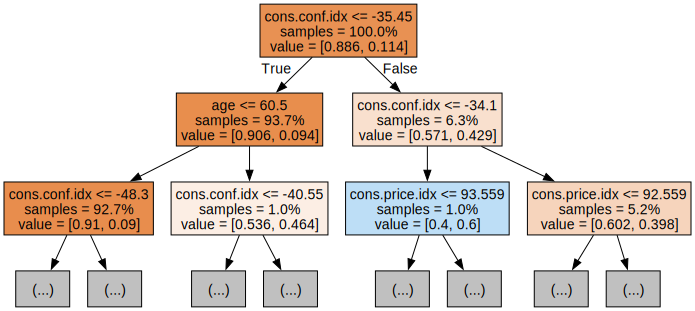

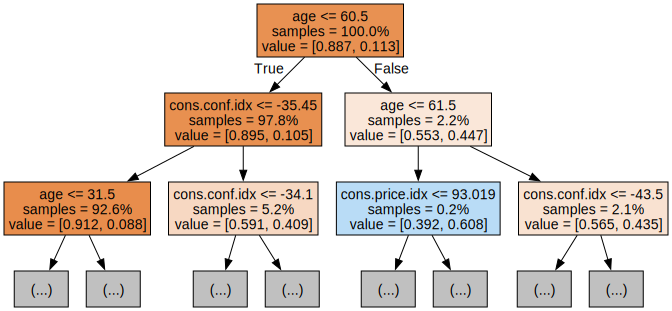

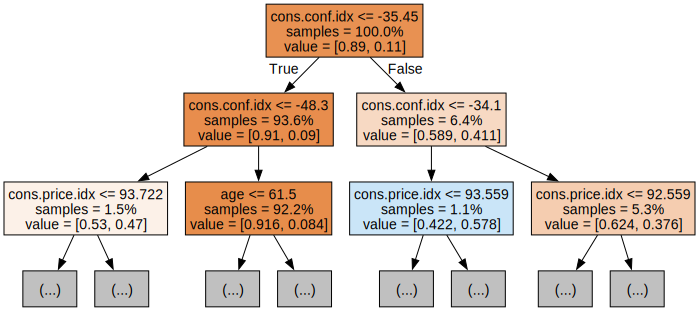

In [9]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Each tree image is limited to only showing the first few nodes. These trees can get very large and difficult to visualize. The colors represent the majority class of each node (box, with red indicating majority 0 (no subscription) and blue indicating majority 1 (subscription). The colors get darker the closer the node gets to being fully 0 or 1. Each node also contains the following information:

- The variable name and value used for splitting
- The % of total samples in each split
- The % split between classes in each split

## Hyperparameter tuning

The code below uses Scikit-Learn’s `RandomizedSearchCV`, which will randomly search parameters within a range per hyperparameter. We define the hyperparameters to use and their ranges in the param_dist dictionary. In our case, we are using:

- `n_estimators`: the number of decision trees in the forest. Increasing this hyperparameter generally improves the model's performance; however, it also increases its computational cost during both training and prediction.
- `max_depth`: the maximum depth of each decision tree in the forest. Setting a higher value for max_depth can lead to overfitting, while setting it too low can lead to underfitting.

In [10]:
param_dist = {'n_estimators': [randint(50,500)],
              'max_depth': [randint(1,20)]}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist , n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

/Users/lalo/Applications/Miniconda3/envs/jcsra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': [18], 'n_estimators': [261]}"
,n_iter,5
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [11]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 261, 'max_depth': 18}


## Assess model performance

Next, the confusion matrix illustrates how the predicted values align with the correct predictions. We can use this to understand the tradeoff between false positives (top right) and false negatives (bottom left). We can plot the confusion matrix using this code:

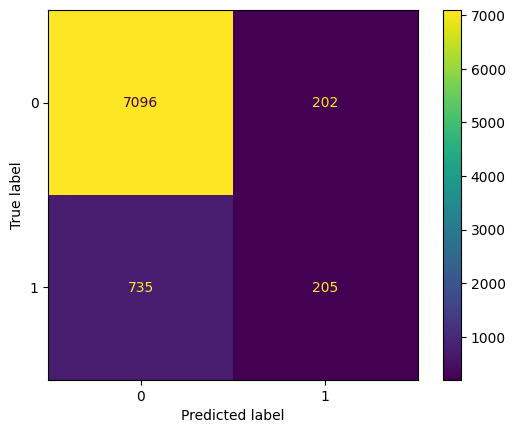

In [12]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8862588006797767
Precision: 0.5036855036855037
Recall: 0.21808510638297873


The code below plots the importance of each feature, using the model’s internal score to find the best way to split the data within each decision tree. This indicates that the consumer confidence index at the time of the call was the most significant predictor of whether the person subscribed.

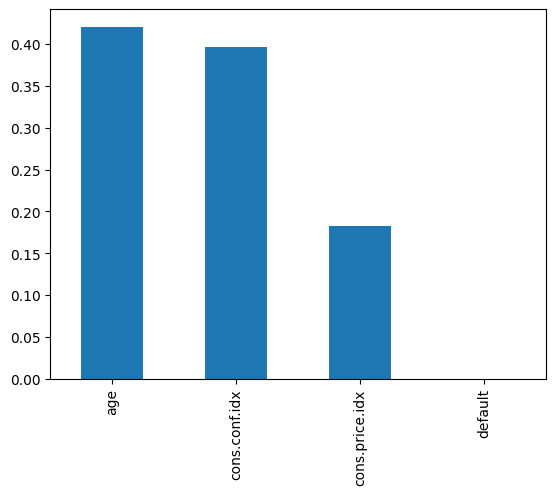

In [14]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();